# C964 Predictive Model Training & Evaluation

## Setup

In [1]:
import logging

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold, cross_val_predict, cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    StandardScaler,
)
from sklego.meta import ZeroInflatedRegressor

%matplotlib inline

logging.getLogger("root").setLevel(logging.ERROR)

In [2]:
# Features file manually encodes the variable type for each selected column for use in training
meta = pd.read_csv("../data/features.csv")
meta

,variable,kind
0,HDD65,numerical
1,CDD65,numerical
2,TYPEHUQ,categorical
3,CELLAR,boolean
4,BASEFIN,boolean
...,...,...
89,EVCHRGHOME,boolean
90,NHSLDMEM,numerical
91,SQFTEST,numerical
92,DBT1,numerical


In [3]:
# Categorize variable by type
numerical_vars = meta.query("`kind` == 'numerical'")["variable"].tolist()
boolean_vars = meta.query("`kind` == 'boolean'")["variable"].tolist()
ordinal_vars = meta.query("`kind` == 'ordinal'")["variable"].tolist()
categorical_vars = meta.query("`kind` == 'categorical'")["variable"].tolist()

# Define target and feature variables
target_vars = ["TOTALBTU", "BTUEL", "BTUNG", "BTULP", "BTUFO", "BTUWD"]
feature_vars = [col for col in list(meta["variable"]) if col not in target_vars]

# Assign features by type
numerical_features = [col for col in numerical_vars if col in feature_vars]
boolean_features = [col for col in boolean_vars if col in feature_vars]
ordinal_features = [col for col in ordinal_vars if col in feature_vars]
categorical_features = [col for col in categorical_vars if col in feature_vars]

# Display counts of features by type
print("numerical_features", len(numerical_features))
print("boolean_features", len(boolean_features))
print("ordinal_features", len(ordinal_features))
print("categorical_features", len(categorical_features))
print("targets", len(target_vars))

numerical_features 36
boolean_features 22
ordinal_features 6
categorical_features 30
targets 6


In [4]:
# Define Pandas datatypes for variables
dtype = {}
for col in categorical_vars + ordinal_vars:
    dtype[col] = "category"
for col in boolean_vars:
    dtype[col] = "boolean"
for col in numerical_vars:
    dtype[col] = "float64"

# Import survey response dataset
data = pd.read_csv(
    "../data/recs2020_public_v5.csv",
    usecols=lambda c: c in (feature_vars + target_vars),
    dtype=dtype,
    na_values=["-2"],
)

targets = data[target_vars]
data = data[feature_vars]

data.head()

,HDD65,CDD65,TYPEHUQ,CELLAR,BASEFIN,ATTIC,ATTICFIN,STORIES,SIZEOFGARAGE,YEARMADERANGE,...,H2OAPT,WHEATSIZ,FUELH2O,MORETHAN1H2O,FUELH2O2,EVCHRGHOME,NHSLDMEM,SQFTEST,DBT1,DBT99
0,3844.0,1679.0,2,False,<NA>,False,<NA>,1,2,4,...,<NA>,3,1,False,NaN,<NA>,2.0,2100.0,92.9,21.6
1,3766.0,1458.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,5,...,False,2,1,False,NaN,<NA>,1.0,590.0,91.3,16.1
2,3819.0,1696.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,True,4,1,False,NaN,<NA>,1.0,900.0,92.9,21.6
3,2614.0,1718.0,2,False,<NA>,False,<NA>,2,2,5,...,<NA>,3,1,False,NaN,<NA>,2.0,2100.0,91.8,25.1
4,4219.0,1363.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,True,2,1,False,NaN,<NA>,2.0,800.0,81.8,13.0


In [5]:
def create_constant_imputer(fill_value):
    return SimpleImputer(
        strategy="constant", fill_value=fill_value, add_indicator=False
    )


def create_ordinal_transformer(*, fill_value="0", categories="auto"):
    return make_pipeline(
        create_constant_imputer(fill_value), OrdinalEncoder(categories=categories)
    )


default_ordinal_transformer = create_ordinal_transformer()

preprocess_ordinal = ColumnTransformer(
    [
        (
            "SIZEOFGARAGE",
            create_ordinal_transformer(categories=[["0", "1", "2", "3"]]),
            ["SIZEOFGARAGE"],
        ),
        (
            "YEARMADERANGE",
            create_ordinal_transformer(
                categories=[["1", "2", "3", "4", "5", "6", "7", "8", "9"]]
            ),
            ["YEARMADERANGE"],
        ),
        (
            "TYPEGLASS",
            create_ordinal_transformer(categories=[["1", "2", "3"]]),
            ["TYPEGLASS"],
        ),
        (
            "ADQINSUL",
            create_ordinal_transformer(categories=[["1", "2", "3", "4"]]),
            ["ADQINSUL"],
        ),
        (
            "WASHTEMP",
            create_ordinal_transformer(categories=[["0", "1", "2", "3", "0"]]),
            ["WASHTEMP"],
        ),
        (
            "WHEATSIZ",
            create_ordinal_transformer(categories=[["1", "2", "3", "4"]]),
            ["WHEATSIZ"],
        ),
    ],
    remainder=default_ordinal_transformer,
)


preprocess_categorical = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)


preprocess_boolean = make_pipeline(
    create_constant_imputer(fill_value=False),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)


normalized_transformer = make_pipeline(
    PowerTransformer(method="yeo-johnson", standardize=True)
)

standardized_transformer = make_pipeline(
    create_constant_imputer(fill_value=0), StandardScaler()
)

preprocess_numerical = ColumnTransformer(
    [("normalize", normalized_transformer, ["HDD65", "CDD65", "SQFTEST"])],
    remainder=standardized_transformer,
)

preprocessor = ColumnTransformer(
    [
        ("numerical", preprocess_numerical, numerical_features),
        ("boolean", preprocess_boolean, boolean_features),
        ("ordinal", preprocess_ordinal, ordinal_features),
        ("categorical", preprocess_categorical, categorical_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                              SimpleImputer(fill_value=0,
                                                                                            strategy='constant')),
                                                                             ('standardscaler',
                                                                              StandardScaler())]),
                                                   transformers=[('normalize',
                                                                  Pipeline(steps=[('powertransformer',
                                                                                   PowerTransformer())]),
                                                                  ['HDD65',
                                                                   'CDD65',
                                                                   'SQFTEST'])]),
                                 ['HDD65', 'CDD65', 'BEDROOMS', 'NCOMBATH',
                                  'N...
                                 ['TYPEHUQ', 'STORIES', 'WALLTYPE', 'ROOFTYPE',
                                  'FUELPOOL', 'FUELTUB', 'TYPERFR1', 'TYPERFR2',
                                  'LOCRFRI2', 'UPRTFRZR', 'RANGEFUEL',
                                  'COOKTOPFUEL', 'OVENFUEL', 'OUTGRILLFUEL',
                                  'DWCYCLE', 'TOPFRONT', 'DRYRFUEL', 'EQUIPM',
                                  'FUELHEAT', 'EQUIPAUXTYPE', 'FUELAUX',
                                  'HUMIDTYPE', 'ACEQUIPM_PUB',
                                  'ACEQUIPAUXTYPE_PUB', 'DEHUMTYPE',
                                  'TYPETHERM', 'HEATCNTL', 'COOLCNTL',
                                  'FUELH2O', 'FUELH2O2'])])

In [6]:
target_var = "TOTALBTU"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(random_state=42),
    regressor=TransformedTargetRegressor(
        regressor=HistGradientBoostingRegressor(random_state=42),
        transformer=normalized_transformer,
    ),
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(random_state=42),
                      regressor=TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=42),
                                                           transformer=Pipeline(steps=[('powertransformer',
                                                                                        PowerTransformer())])))

In [7]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model, data, target, cv=cv, scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame(
    {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]}
)
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.672 ± 0.027
Mean Absolute Error (MAE):
19017.406 ± 578.358


,R2,MAE
0,0.708513,18238.110075
1,0.669448,19225.484211
2,0.644087,19820.880536
3,0.689412,18815.108295
4,0.647739,18987.444435


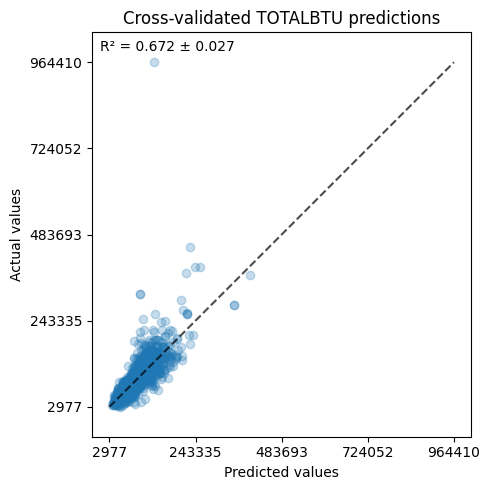

In [8]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv,
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.25},
    random_state=42,
)
ax.set_title("Cross-validated TOTALBTU predictions")
ax.text(
    0.02,
    0.98,
    f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
plt.tight_layout()
plt.show()

In [9]:
target_var = "BTUEL"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(random_state=42),
    regressor=TransformedTargetRegressor(
        regressor=HistGradientBoostingRegressor(random_state=42),
        transformer=normalized_transformer,
    ),
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(random_state=42),
                      regressor=TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=42),
                                                           transformer=Pipeline(steps=[('powertransformer',
                                                                                        PowerTransformer())])))

In [10]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring=["r2", "neg_mean_absolute_error"],
)

scores = pd.DataFrame(
    {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]}
)
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.593 ± 0.031
Mean Absolute Error (MAE):
9972.601 ± 104.688


,R2,MAE
0,0.586628,9944.192293
1,0.608123,9932.319337
2,0.543462,10118.952686
3,0.623350,10025.896403
4,0.602652,9841.645172


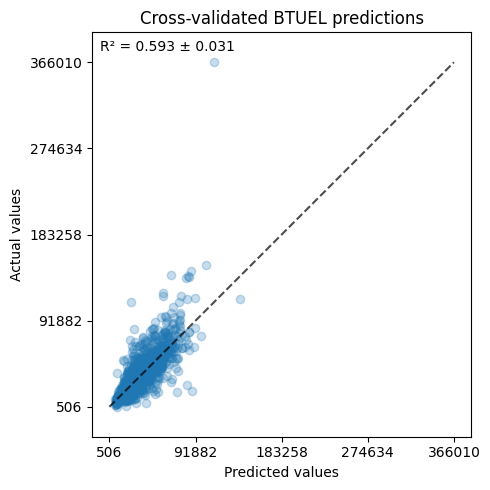

In [11]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv,
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.25},
    random_state=42,
)
ax.set_title("Cross-validated BTUEL predictions")
ax.text(
    0.02,
    0.98,
    f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
plt.tight_layout()
plt.show()

In [12]:
target_var = "BTUNG"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(random_state=42),
    regressor=TransformedTargetRegressor(
        regressor=HistGradientBoostingRegressor(random_state=42),
        transformer=normalized_transformer,
    ),
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(random_state=42),
                      regressor=TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=42),
                                                           transformer=Pipeline(steps=[('powertransformer',
                                                                                        PowerTransformer())])))

In [13]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring=["r2", "neg_mean_absolute_error"],
)

scores = pd.DataFrame(
    {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]}
)
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.777 ± 0.027
Mean Absolute Error (MAE):
10063.241 ± 560.196


,R2,MAE
0,0.822805,9213.913527
1,0.764831,10690.059273
2,0.751764,10063.690282
3,0.778678,9933.061656
4,0.766087,10415.479001


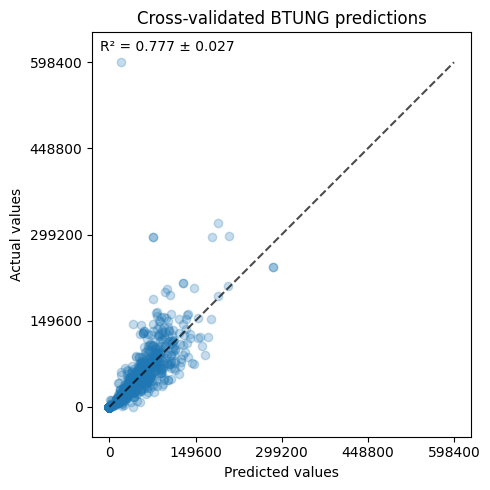

In [14]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv,
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.25},
    random_state=42,
)
ax.set_title("Cross-validated BTUNG predictions")
ax.text(
    0.02,
    0.98,
    f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
plt.tight_layout()
plt.show()

In [15]:
target_var = "BTULP"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(random_state=42),
    regressor=TransformedTargetRegressor(
        regressor=HistGradientBoostingRegressor(random_state=42),
        transformer=normalized_transformer,
    ),
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(random_state=42),
                      regressor=TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=42),
                                                           transformer=Pipeline(steps=[('powertransformer',
                                                                                        PowerTransformer())])))

In [16]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model, data, target, cv=cv, scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame(
    {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]}
)
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.795 ± 0.035
Mean Absolute Error (MAE):
1505.107 ± 169.550


,R2,MAE
0,0.810375,1564.228848
1,0.740847,1594.382621
2,0.786409,1708.646922
3,0.836773,1338.243875
4,0.800233,1320.034175


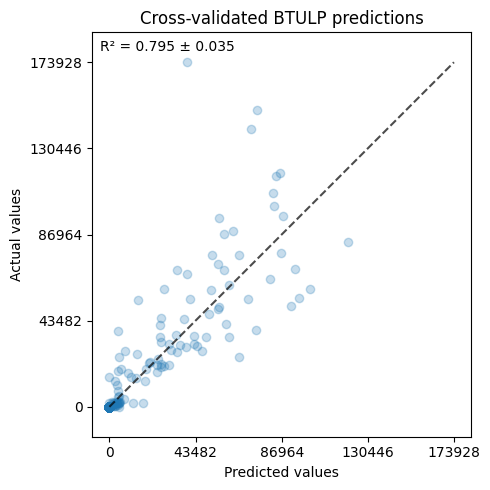

In [17]:
y_pred = cross_val_predict(model, data, target, cv=cv)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.25},
    random_state=42,
)
ax.set_title("Cross-validated BTULP predictions")
ax.text(
    0.02,
    0.98,
    f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
plt.tight_layout()
plt.show()

In [18]:
target_var = "BTUFO"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(random_state=42),
    regressor=TransformedTargetRegressor(
        regressor=HistGradientBoostingRegressor(random_state=42),
        transformer=normalized_transformer,
    ),
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(random_state=42),
                      regressor=TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=42),
                                                           transformer=Pipeline(steps=[('powertransformer',
                                                                                        PowerTransformer())])))

In [19]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model, data, target, cv=cv, scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame(
    {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]}
)
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.846 ± 0.014
Mean Absolute Error (MAE):
1665.228 ± 231.206


,R2,MAE
0,0.839785,1713.589259
1,0.857730,1373.249184
2,0.824859,1942.584905
3,0.849497,1804.465194
4,0.859684,1492.251363


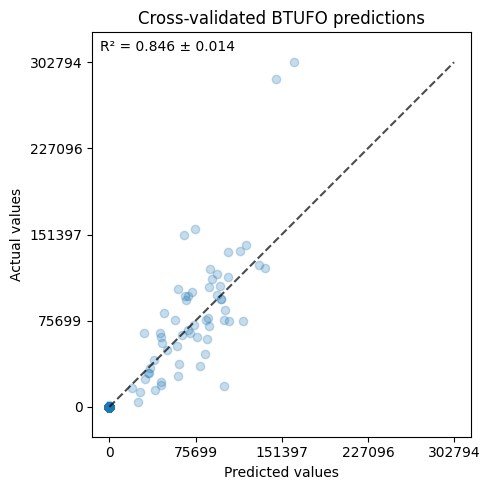

In [20]:
y_pred = cross_val_predict(model, data, target, cv=cv)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.25},
    random_state=42,
)
ax.set_title("Cross-validated BTUFO predictions")
ax.text(
    0.02,
    0.98,
    f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
plt.tight_layout()
plt.show()

In [21]:
target_var = "BTUWD"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(random_state=42),
    regressor=TransformedTargetRegressor(
        regressor=HistGradientBoostingRegressor(random_state=42),
        transformer=normalized_transformer,
    ),
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(random_state=42),
                      regressor=TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=42),
                                                           transformer=Pipeline(steps=[('powertransformer',
                                                                                        PowerTransformer())])))

In [22]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model, data, target, cv=cv, scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame(
    {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]}
)
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.616 ± 0.013
Mean Absolute Error (MAE):
1913.065 ± 120.113


,R2,MAE
0,0.611246,2009.315538
1,0.617710,1954.829665
2,0.602974,1988.764431
3,0.638193,1901.423613
4,0.611342,1710.989758


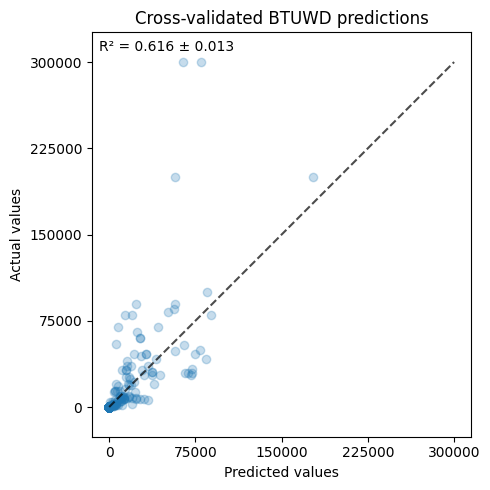

In [23]:
y_pred = cross_val_predict(model, data, target, cv=cv)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.25},
    random_state=42,
)
ax.set_title("Cross-validated BTUWD predictions")
ax.text(
    0.02,
    0.98,
    f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
plt.tight_layout()
plt.show()

In [24]:
target = targets

regressor = MultiOutputRegressor(
    ZeroInflatedRegressor(
        classifier=HistGradientBoostingClassifier(random_state=42),
        regressor=TransformedTargetRegressor(
            regressor=HistGradientBoostingRegressor(random_state=42),
            transformer=normalized_transformer,
        ),
    )
)
regressor

MultiOutputRegressor(estimator=ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(random_state=42),
                                                     regressor=TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=42),
                                                                                          transformer=Pipeline(steps=[('powertransformer',
                                                                                                                       PowerTransformer())]))))

In [25]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model, data, target, cv=cv, scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame(
    {"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]}
)
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.717 ± 0.017
Mean Absolute Error (MAE):
7356.108 ± 186.743


,R2,MAE
0,0.729892,7113.891590
1,0.709781,7461.720715
2,0.692259,7607.253294
3,0.735984,7303.033173
4,0.714623,7294.640651


In [26]:
model.fit(data, target)

filename = "model.joblib"
joblib.dump(model, filename)

['model.joblib']